In [2]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [3]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 2.6MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [1]:
import xml.etree.ElementTree as ET
import os
import numpy as np

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/keras-yolo3


###### 資料集轉換
### 1547張圖片
2858個有戴口罩的邊界框（代號1）
895個未配戴口罩的邊界框（代號0）
117個未正確配戴口罩的邊界框(代號2，有口罩但是配戴方法錯誤）
209個配戴無防護能力口罩的邊界框（代號3）

In [5]:
classes = ["NoMask", "GoodMask", "BadMask", "NoDefMask"]
trainPath = './day49_mask_train.txt'
if not os.path.exists(trainPath):
    list_file = open('./model_data/day49_mask_classes.txt', 'w')
    for data in classes:
        list_file.write(data)
        list_file.write('\n')
    list_file.close()

    maskPath = './data/masked_faces/voc/'
    maskImgPath = './data/masked_faces/imgs/'
    maskFileList = os.listdir(maskPath)
    

    def convert_annotation(fileList, imgPath, path):
        resList = []
        for file in fileList:
            in_file = open(os.path.join(path,file))
            tree=ET.parse(in_file)
            root = tree.getroot()
            filename = root.find('filename').text
            data = os.path.join(imgPath,filename)

            for obj in root.iter('object'):
                difficult = obj.find('difficult').text
                cls = obj.find('name').text
                if int(cls) >= len(classes) or int(difficult) == 1:
                    continue
                cls_id = cls
                xmlbox = obj.find('bndbox')
                b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
                data += (" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))
            resList.append(data)
        return resList

    alllist = convert_annotation(maskFileList, maskImgPath, maskPath)
    np.random.shuffle(alllist)

    list_file = open(trainPath, 'w')
    for data in alllist:
        list_file.write(data)
        list_file.write('\n')
    list_file.close()
    print('Traindata Create Over')
else:
    print("Model exist")


Traindata Create Over


In [0]:
# 當圖片有損壞可用以下代碼找出
# import keras
# from PIL import Image

# kangarooFileList = os.listdir('./data/kangaroo/images/')

# for img in kangarooFileList:
#     try:
#         img2 = Image.open(os.path.join('./data/kangaroo/images/',img))
#         img2.save('test.jpg')
#     except:
#         print(f'{img} loading error')
#         continue

In [3]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [4]:
annotation_path = 'day49_mask_train.txt'
log_dir = 'logs/day49_mask_local/'
classes_path = 'model_data/day49_mask_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
input_shape = (980,980)

is_tiny_version = len(anchors) == 6
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5')

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                             monitor='val_loss', 
                             save_weights_only=True, 
                             save_best_only=True, 
                             period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation 9:1
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines) * val_split)
num_train = len(lines) - num_val


model.compile(optimizer=Adam(lr=1e-3), 
              loss={'yolo_loss': lambda y_true, y_pred: y_pred})

batch_size = 16
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
hist_model = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=10,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
model.save_weights(log_dir + 'trained_weights_stage_1.h5')


# 把所有 layer 都改為 trainable
# for i in range(len(model.layers)):
#     model.layers[i].trainable = True
# model.compile(optimizer=Adam(lr=1e-4), 
#               loss={'yolo_loss': lambda y_true, y_pred: y_pred})
# print('Unfreeze all of the layers.')

# batch_size = 5
# print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
# hist_model = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
#         steps_per_epoch=max(1, num_train//batch_size),
#         validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
#         validation_steps=max(1, num_val//batch_size),
#         epochs=100,
#         initial_epoch=50,
#         callbacks=[logging, checkpoint, reduce_lr, early_stopping])
# model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 4 classes.


C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 27) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((27,) vs (255,)).
  weight_values[i].shape))
C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 27) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((27,) vs (255,)).
  weight_values[i].shape))
C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\keras\engine\saving

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Train on 1393 samples, val on 154 samples, with batch size 16.


Epoch 1/10


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[16,32,980,980] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_1/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[loss/add_74/_2891]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[16,32,980,980] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_1/convolution}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

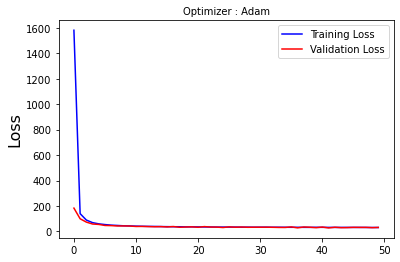

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [6]:
from PIL import Image
from yolo import YOLO
image = Image.open('testimg/0002.jpg')

In [2]:
from yolo import YOLO
yolo_model = YOLO(model_path='logs/day49_mask/trained_weights_final_mask_ALL.h5', classes_path="model_data/day49_mask_classes.txt")
r_image = yolo_model.detect_image(image)

Using TensorFlow backend.
C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ggaar\Anaconda3\envs\cv

C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\keras\utils\io_utils.py:186: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.data = h5py.File(path,)




logs/day49_mask/trained_weights_final_mask_ALL.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(416, 416, 3)
Found 2 boxes for img
GoodMask 0.86 (190, 136) (317, 275)
NoMask 0.75 (767, 100) (905, 284)
3.1353748999999986


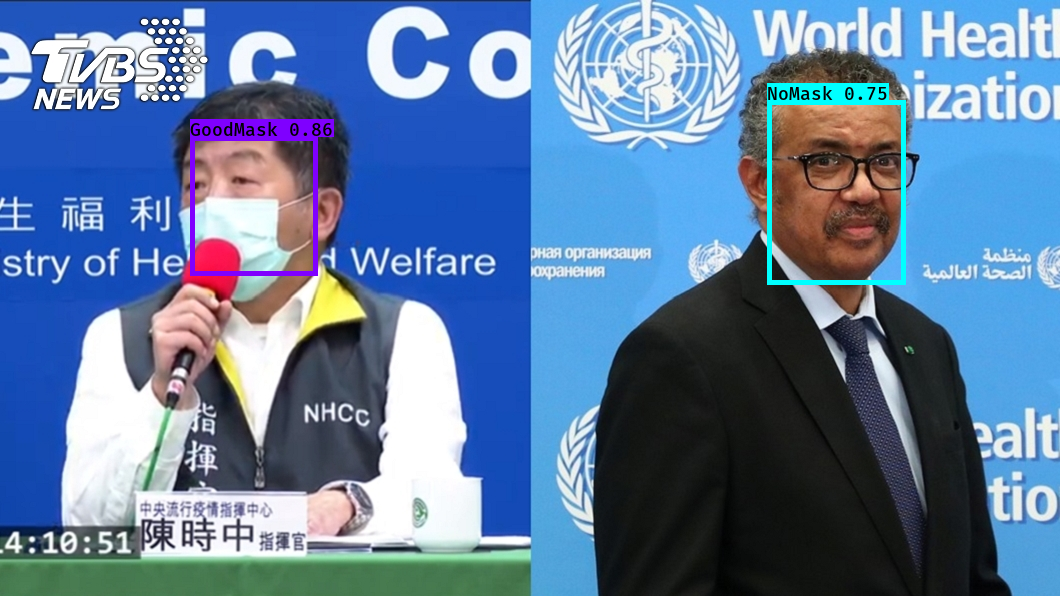

In [3]:
r_image

In [4]:
from PIL import Image
image = Image.open('testimg/0002.jpg')

In [5]:
from yolo import YOLO
yolo_model = YOLO(model_path='logs/day49_mask/trained_weights_final_mask.h5', classes_path="model_data/day49_mask_classes.txt")
r_image = yolo_model.detect_image(image)

logs/day49_mask/trained_weights_final_mask.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 2 boxes for img
GoodMask 0.93 (189, 121) (318, 290)
NoMask 0.81 (758, 115) (909, 271)
1.426487999999999


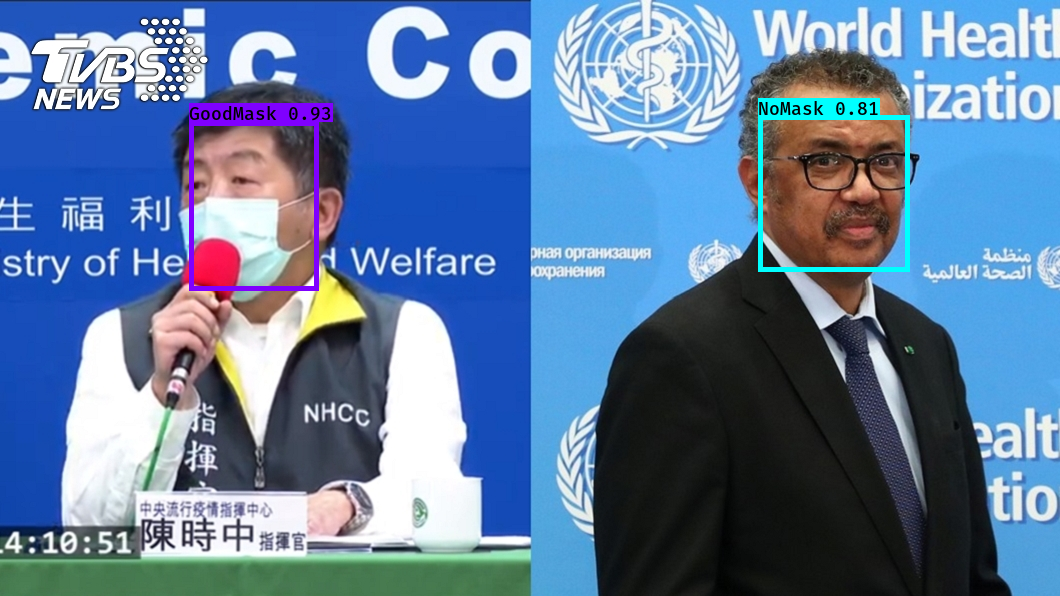

In [6]:
r_image

logs/day49_mask/trained_weights_final_mask.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 14 boxes for img
GoodMask 0.35 (261, 7) (278, 37)
GoodMask 0.36 (217, 31) (236, 52)
GoodMask 0.43 (149, 45) (167, 69)
GoodMask 0.43 (68, 40) (87, 63)
GoodMask 0.45 (14, 26) (35, 55)
GoodMask 0.58 (121, 24) (139, 46)
GoodMask 0.58 (251, 41) (271, 61)
GoodMask 0.60 (172, 40) (186, 62)
GoodMask 0.66 (164, 24) (182, 43)
GoodMask 0.66 (126, 46) (145, 67)
GoodMask 0.73 (99, 39) (120, 60)
NoMask 0.32 (79, 26) (97, 45)
NoMask 0.43 (198, 36) (215, 56)
NoMask 0.55 (3, 4) (26, 24)
4.386571600000025


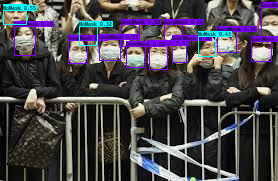

In [15]:
image = Image.open('data/masked_faces/imgs/0c95740a.jpg')
yolo_model = YOLO(model_path='logs/day49_mask/trained_weights_final_mask.h5', classes_path="model_data/day49_mask_classes.txt")
r_image = yolo_model.detect_image(image)
r_image

C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\keras\utils\io_utils.py:186: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.data = h5py.File(path,)


logs/day49_mask/trained_weights_final_mask_ALL.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
NoDefMask 0.79 (42, 38) (226, 139)
2.468177900009323


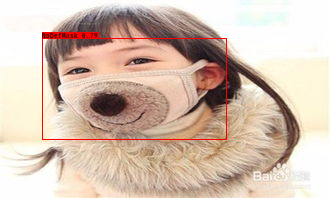

In [7]:
image = Image.open('testimg/0004.jpg')
yolo_model = YOLO(model_path='logs/day49_mask/trained_weights_final_mask_ALL.h5', classes_path="model_data/day49_mask_classes.txt")
r_image = yolo_model.detect_image(image)
r_image

logs/day49_mask/trained_weights_final_mask.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
NoDefMask 0.96 (63, 31) (209, 125)
2.092870699998457


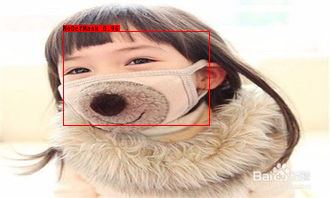

In [9]:
image = Image.open('testimg/0004.jpg')
yolo_model = YOLO(model_path='logs/day49_mask/trained_weights_final_mask.h5', classes_path="model_data/day49_mask_classes.txt")
r_image = yolo_model.detect_image(image)
r_image

In [1]:
from PIL import Image
from yolo_video import YOLO
import yolo
vedio = 'testimg/001.mp4'
yolo_model = YOLO(model_path='logs/day49_mask/trained_weights_final_mask.h5', classes_path="model_data/day49_mask_classes.txt")
r_vedio = yolo.detect_video(yolo_model, vedio, 'testimg/002.mp4')


Using TensorFlow backend.
C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ggaar\Anaconda3\envs\cv

C:\Users\ggaar\Anaconda3\envs\cvMarathon\lib\site-packages\keras\utils\io_utils.py:186: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.data = h5py.File(path,)




logs/day49_mask/trained_weights_final_mask.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
!!! TYPE: <class 'str'> <class 'int'> <class 'float'> <class 'tuple'>
(416, 416, 3)
Found 1 boxes for img
GoodMask 0.85 (559, 185) (733, 366)
2.990462300000001
(416, 416, 3)
Found 1 boxes for img
GoodMask 0.85 (560, 185) (733, 366)
0.17962539999999905
(416, 416, 3)
Found 1 boxes for img
GoodMask 0.85 (560, 184) (733, 366)
0.1820623999999995
(416, 416, 3)
Found 1 boxes for img
GoodMask 0.85 (560, 183) (732, 366)
0.18148250000000132
(416, 416, 3)
Found 1 boxes for img
GoodMask 0.86 (561, 183) (733, 365)
0.18141430000000014
(416, 416, 3)
Found 2 boxes for img
GoodMask 0.87 (561, 183) (733, 366)
NoMask 0.32 (1069, 242) (1122, 348)
0.1821280999999999
(416, 416, 3)
Found 1 boxes for img
GoodMask 0.86 (561, 183) (733, 366)
0.17984180000000194
(416, 416, 3)
Found 1 boxes for img
GoodMask 0.86 (561, 183) (733, 365)
0.18

(416, 416, 3)
Found 3 boxes for img
GoodMask 0.86 (572, 145) (739, 358)
NoMask 0.38 (92, 152) (169, 305)
NoMask 0.61 (1069, 248) (1118, 348)
0.18405190000000005
(416, 416, 3)
Found 3 boxes for img
GoodMask 0.85 (572, 146) (739, 360)
NoMask 0.37 (91, 152) (168, 306)
NoMask 0.58 (1069, 248) (1118, 348)
0.1847846000000004
(416, 416, 3)
Found 3 boxes for img
GoodMask 0.84 (572, 147) (740, 360)
NoMask 0.38 (92, 152) (168, 306)
NoMask 0.57 (1069, 249) (1118, 348)
0.18469800000000447
(416, 416, 3)
Found 3 boxes for img
GoodMask 0.83 (571, 187) (738, 359)
NoMask 0.38 (92, 152) (169, 305)
NoMask 0.67 (1069, 250) (1118, 347)
0.18485850000000426
(416, 416, 3)
Found 3 boxes for img
GoodMask 0.83 (571, 187) (739, 360)
NoMask 0.37 (92, 152) (169, 306)
NoMask 0.53 (1068, 245) (1118, 349)
0.19000199999999978
(416, 416, 3)
Found 3 boxes for img
GoodMask 0.83 (571, 186) (739, 360)
NoMask 0.40 (91, 152) (169, 305)
NoMask 0.60 (1068, 246) (1118, 345)
0.18537179999999864
(416, 416, 3)
Found 3 boxes for img

NoMask 0.48 (1067, 246) (1120, 341)
0.1826457000000019
(416, 416, 3)
Found 2 boxes for img
GoodMask 0.90 (574, 148) (730, 357)
NoMask 0.56 (1067, 247) (1121, 344)
0.18778879999999987
(416, 416, 3)
Found 2 boxes for img
GoodMask 0.89 (575, 147) (730, 358)
NoMask 0.35 (1067, 247) (1120, 338)
0.18328300000000297
(416, 416, 3)
Found 2 boxes for img
GoodMask 0.88 (574, 146) (731, 359)
NoMask 0.40 (1066, 249) (1121, 340)
0.183502500000003
(416, 416, 3)
Found 2 boxes for img
GoodMask 0.88 (574, 145) (731, 359)
NoMask 0.34 (1065, 248) (1121, 341)
0.18508520000000317
(416, 416, 3)
Found 2 boxes for img
GoodMask 0.88 (574, 147) (731, 357)
NoMask 0.32 (1066, 245) (1121, 340)
0.1839184999999972
(416, 416, 3)
Found 2 boxes for img
GoodMask 0.89 (574, 147) (731, 356)
NoMask 0.31 (1066, 246) (1121, 338)
0.1826711000000003
(416, 416, 3)
Found 1 boxes for img
GoodMask 0.89 (574, 147) (731, 356)
0.18689609999999846
(416, 416, 3)
Found 1 boxes for img
GoodMask 0.89 (574, 147) (732, 356)
0.187702200000003